In [112]:
# import packages 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import h2o
from h2o.frame import H2OFrame
from h2o.estimators import H2OXGBoostEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

plt.style.use('seaborn')
%matplotlib inline

---
**Goal:**
- In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.
- How many people each employee manages? 
- Build a model to predict the salary of each employee.
- Describe the main factors impacting employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?

In [2]:
# import dataset 
company = pd.read_csv('company_hierarchy.csv')
company.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [3]:
employee = pd.read_csv('employee.csv')
employee.head(3)

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2


In [4]:
df = pd.merge(company,employee)
df.head()

,employee_id,boss_id,dept,signing_bonus,salary,degree_level,sex,yrs_experience
0,46456,175361.0,sales,0,213000.0,Bachelor,M,5
1,104708,29733.0,HR,0,79000.0,Bachelor,F,3
2,120853,41991.0,sales,0,199000.0,High_School,M,5
3,142630,171266.0,HR,0,143000.0,PhD,F,13
4,72711,198240.0,sales,0,235000.0,Master,M,1


# In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.

In [5]:
levels = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']
df.loc[df['dept'] == 'CEO', 'level'] = 'CEO'

In [6]:
for i in range(len(levels) - 1):
    boss_level = levels[i]
    empl_level = levels[i+1]
    boss_id = df[df['level']==boss_level]['employee_id']
    df.loc[df['boss_id'].isin(boss_id),'level'] = empl_level

In [7]:
df['level'].value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

# How many people each employee manages?

In [8]:
# find the managed employees for each employee
df['counts'] = 0

for level in ['IC', 'MM', 'D', 'VP', 'E']:
    boss_ids = df[df['level'] == level]['boss_id']
    employee_ids = df[df['level'] == level]['employee_id']
    for b_id, e_id in zip(boss_ids, employee_ids):
        e_counts = int(1 + df.loc[df['employee_id'] == e_id, 'counts'])
        b_counts = int(df.loc[df['employee_id'] == b_id, 'counts'])
        df.loc[df['employee_id'] == b_id, 'counts'] = e_counts + b_counts

In [9]:
df[['employee_id','level','counts']]

,employee_id,level,counts
0,46456,IC,0
1,104708,IC,0
2,120853,IC,0
3,142630,MM,16
4,72711,IC,0
...,...,...,...
9995,45022,IC,0
9996,173414,IC,0
9997,194688,IC,0
9998,11698,IC,0


# Build a model to predict the salary of each employee.

`Target`: Salary

`Variables`:

**Category:** dept,degree_level,sex,level,signing_bonus

**Numeric:** yrs_experience,counts

## EDA

In [10]:
pd.crosstab(index = df.sex,columns = df.level)

level,CEO,D,E,IC,MM,VP
sex,,,,,,
F,0,47,1,3240,264,9
M,1,113,3,5760,536,26


From the Frequencies Table, there is a huge difference between employment in Sex in different level of employment

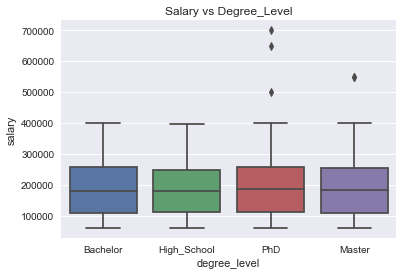

In [11]:
sns.boxplot(data=df, x='degree_level', y='salary')
plt.title('Salary vs Degree_Level')
plt.show()

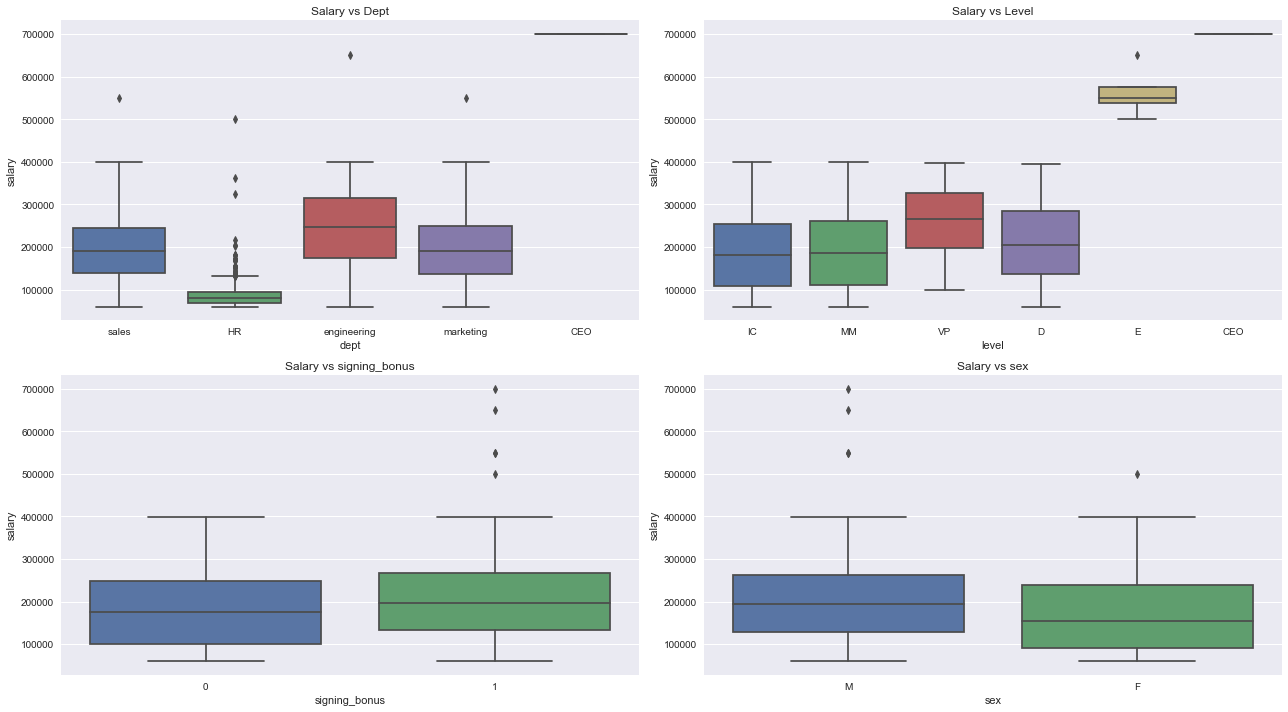

In [14]:
# box plot dept and salary
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
sns.boxplot(data=df, x='dept', y='salary', ax=ax[0, 0])
ax[0, 0].set_title('Salary vs Dept')

sns.boxplot(data=df, x='level', y='salary', ax=ax[0, 1])
ax[0, 1].set_title('Salary vs Level')

sns.boxplot(data=df, x='signing_bonus', y='salary', ax=ax[1, 0])
ax[1, 0].set_title('Salary vs signing_bonus')

sns.boxplot(data=df, x='sex', y='salary', ax=ax[1, 1])
ax[1, 1].set_title('Salary vs sex')

plt.tight_layout()
plt.show()

From boxplot, `Department`, `Employment Level`, `Signing Bonus` and `Sex` have impact on the `Salary`

But `degree_level` seems no difference

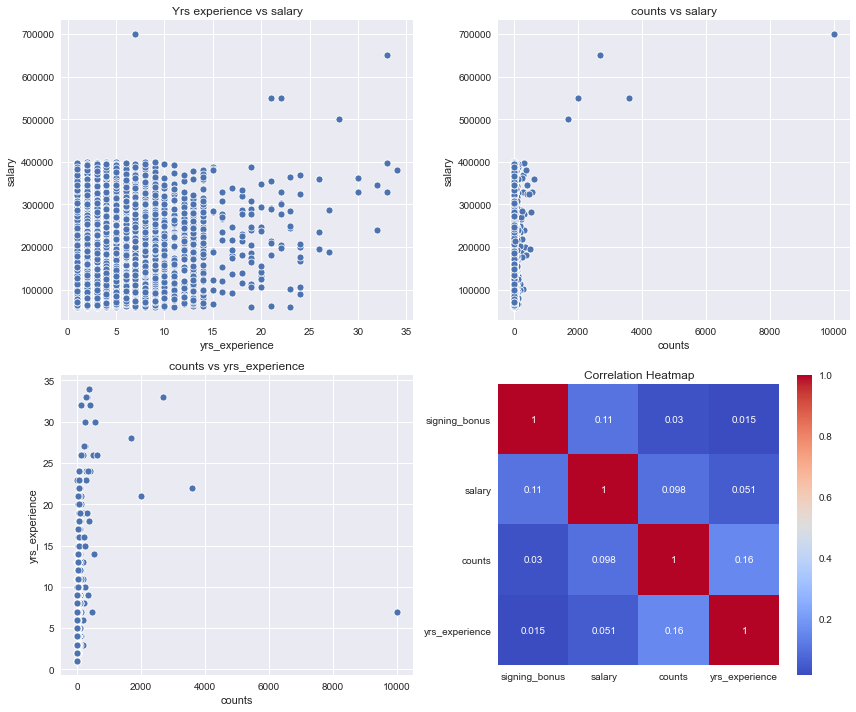

In [36]:
# correlation heatmap between three numerical dataset 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
sns.scatterplot(data = df, x ='yrs_experience',y = 'salary',ax = ax[0,0])
ax[0,0].set_title('Yrs experience vs salary')

sns.scatterplot(data = df, x ='counts',y = 'salary',ax = ax[0,1])
ax[0,1].set_title('counts vs salary')

sns.scatterplot(data = df, x ='counts',y = 'yrs_experience',ax = ax[1,0])
ax[1,0].set_title('counts vs yrs_experience')

sns.heatmap(df[['signing_bonus', 'salary', 'counts', 'yrs_experience']].corr(),
            cmap='coolwarm',
            square=True,
            annot=True,ax = ax[1,1])
ax[1,1].set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

There is some degree that `yrs_experience` is associated with `salary`.

## Model Building 

In [105]:
# normalize data
ss = StandardScaler()
normal_num = pd.DataFrame(ss.fit_transform(
    df[['salary', 'yrs_experience', 'counts']]),
                          columns=['salary', 'yrs_experience', 'counts'])
df = pd.merge(normal_num,
              df[['dept', 'signing_bonus', 'degree_level', 'sex', 'level']],
              left_index=True,
              right_index=True)
df.head(3)

,salary,yrs_experience,counts,dept,signing_bonus,degree_level,sex,level
0,0.268499,0.361992,-0.04259,sales,0,Bachelor,M,IC
1,-1.237637,-0.281664,-0.04259,HR,0,Bachelor,F,IC
2,0.111142,0.361992,-0.04259,sales,0,High_School,M,IC


In [106]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 35 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_matsujun_xzpbe1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.998 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [107]:
# dataframe preparation
h2o_df = H2OFrame(df[[
    'dept', 'signing_bonus', 'salary', 'degree_level', 'sex', 'yrs_experience',
    'level', 'counts'
]])
h2o_df['signing_bonus'] = h2o_df['signing_bonus'].asfactor()
h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,dept,signing_bonus,salary,degree_level,sex,yrs_experience,level,counts
type,enum,enum,real,enum,enum,real,enum,real
mins,,,-1.451194178242179,,,-0.9253187432898452,,-0.04258978614219266
mean,,,-2.0626946331536722e-17,,,-2.9449641510137514e-17,,7.287024445228746e-18
maxs,,,5.742294519731163,,,9.694992375437508,,87.30517073315558
sigma,,,1.0000500037503106,,,1.0000500037503108,,1.0000500037503084
zeros,,,0,,,0,,0
missing,0,0,0,0,0,0,0,0
0,sales,0,0.26849921361707313,Bachelor,M,0.3619916953437735,IC,-0.04258978614219266
1,HR,0,-1.2376374825210954,Bachelor,F,-0.28166352397303573,IC,-0.04258978614219266
2,sales,0,0.11114164834890625,High_School,M,0.3619916953437735,IC,-0.04258978614219266


In [108]:
# Split into 80% training and 20% test dataset
response = 'salary'
predictor = [
    'dept', 'signing_bonus', 'degree_level', 'sex', 'yrs_experience', 'level',
    'counts'
]
train, test = h2o_df.split_frame(ratios=[0.8], seed=42)

In [109]:
# fitting regression
model = H2OXGBoostEstimator(booster='dart',
                                  normalize_type="forest",
                                  seed=1234)
model.train(x=predictor,
            y=response,
            training_frame=train,
            validation_frame=test)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [110]:
# model 
model.model_performance(test_data=test,train = train)


ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 0.7015030485610957
RMSE: 0.8375577881920123
MAE: 0.6501002356922725
RMSLE: NaN
Mean Residual Deviance: 0.7015030485610957


In [120]:
r2_score(test[response],model.predict(test[predictor]))

xgboost prediction progress: |████████████████████████████████████████████| 100%


ValueError: cannot copy sequence with size 1980 to array axis with dimension 1

In [121]:
model

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1599938073267_7


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.5797543541198317
RMSE: 0.7614160190853826
MAE: 0.5888739020618822
RMSLE: NaN
Mean Residual Deviance: 0.5797543541198317

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.7015030485610957
RMSE: 0.8375577881920123
MAE: 0.6501002356922725
RMSLE: NaN
Mean Residual Deviance: 0.7015030485610957

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-09-12 16:49:57,0.043 sec,0.0,1.118984,0.951638,1.252124,1.114179,0.945812,1.241396
1,,2020-09-12 16:49:57,0.081 sec,1.0,0.970116,0.835767,0.941125,0.975951,0.837597,0.952481
2,,2020-09-12 16:49:57,0.102 sec,2.0,0.887276,0.759366,0.787258,0.900573,0.765855,0.811031
3,,2020-09-12 16:49:57,0.122 sec,3.0,0.842855,0.708729,0.710405,0.860819,0.718807,0.741010
4,,2020-09-12 16:49:57,0.143 sec,4.0,0.819837,0.675922,0.672133,0.840922,0.688224,0.707149
5,,2020-09-12 16:49:57,0.164 sec,5.0,0.807723,0.655096,0.652416,0.831321,0.669268,0.691095
6,,2020-09-12 16:49:57,0.186 sec,6.0,0.801289,0.642093,0.642065,0.826728,0.658059,0.683480
7,,2020-09-12 16:49:57,0.208 sec,7.0,0.797661,0.634069,0.636263,0.824550,0.651517,0.679883
8,,2020-09-12 16:49:57,0.232 sec,8.0,0.795756,0.629259,0.633227,0.823171,0.647422,0.677611
9,,2020-09-12 16:49:57,0.254 sec,9.0,0.794144,0.626168,0.630664,0.823091,0.645303,0.677478



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,dept.HR,4498.521484,1.000000,0.688966
1,dept.engineering,892.601624,0.198421,0.136705
2,counts,420.556519,0.093488,0.064410
3,yrs_experience,293.241669,0.065186,0.044911
4,sex.F,69.249313,0.015394,0.010606
5,signing_bonus.0,64.829773,0.014411,0.009929
6,dept.marketing,44.873898,0.009975,0.006873
7,degree_level.PhD,43.609772,0.009694,0.006679
8,degree_level.Master,40.399490,0.008981,0.006187
9,dept.sales,34.645016,0.007701,0.005306


# Describe the main factors impacting employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?

根据xgboost的结果：
dept,counts和yrs_experience，level比较重要

这个公司工资分布是有偏差的：
- 部门的不同，层级以及管理人数都与工资相关。
- 建议管理层调低管理层高工资